<h1 align='center'> Recommender Systems </h1>
<h2 align='center'> with Neural Collaborative Filtering and Matrix Factorization</h2> 

<br>

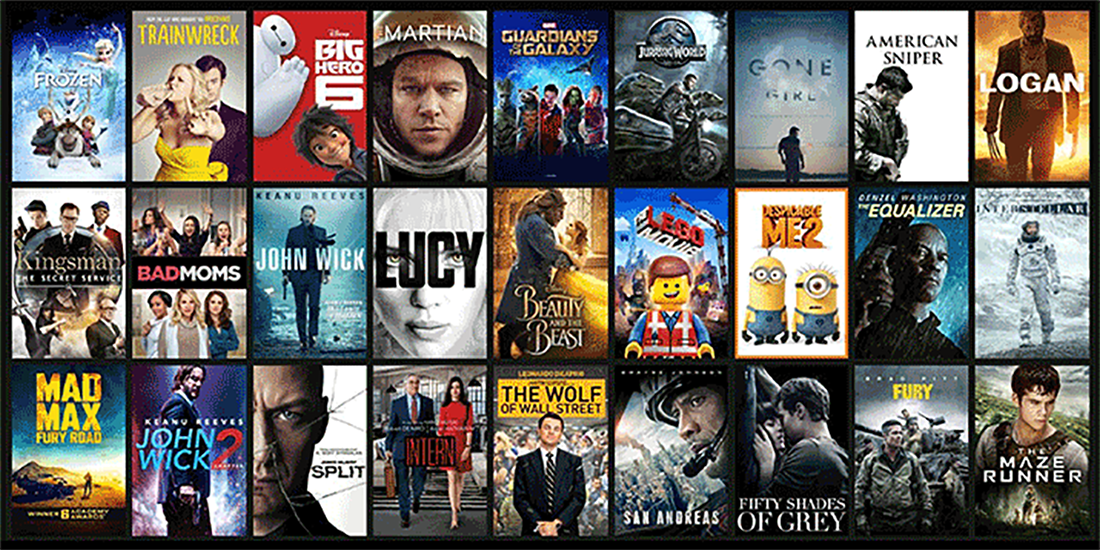

<br>

A Recommender System is a process that seeks to predict or filter user preferences according to the user's choices that are based on explicit (i.e. direct user interactions) and/or implicit feedback (i.e. indirect user interactions) from the user in order to provide recommendations what the user should do next. These choices are usually analyzed through methods such as clustering, nearest neighbor or matrix factorization, and the systems are widely being used in search queries in general, as well as various online products and services such as videos, movies, music, news, and books.

The main idea is that we have a large database of users, but only a few of these people have actually given any explicit feedback from their interactions. This creates a database that is very sparse with insightful information and the key is to find a way to fill the missing entries either through feature engineering where we transform the explicit interactions into implicit ones, and hence create a different problem that is easier to solve or we try to fill the empty entries with different kinds of predictive methods.  

We can break down the methods roughly into three categories where in the first, the recommendation is based solely on the features of items being used by the user which leads to the promotion of other items with similar features. This is the item-based filtering which relies on the descriptions of the item and the profile of the user's past preferences. Item-based recommenders are faster to deploy than user-based when the dataset is large. 

The second system is based on Collaborative Filtering (CF) which uses a combination of your past behavior and the experiences of other people in making the recommendation through an item or user based recommender system. These don't necessary require features about the items or users to be known if the options available are diverse enough.  In the item-based, other users who browsed similar items will be recommended, and on the user based, items that similar users have browsed will be recommended. Both methods demand eventually a large pool of users from which the recommendation can be made, however data sparsity can affect the quality of user-based recommenders.

The third category which is the one that is being used today, uses a combination of the previous systems, for example through low-rank matrix factorization that decomposes large matrices into compressed representation of the data with Singular Value Decomposition (SVD) or with deep learning systems through learned embeddings. The benefits of using the latest hybrid methods is that they are easier to scale to larger data sets and can better derive both tastes and preferences from the user patterns than the previous two, which rely heavily on the distances between the specific data points that are usually quite sparsely represented in large datasets, and hence, can lead to overfitting or just noisy representations of user tastes and preferences as there is just not enough information available. Once combined though, the methods can provide recommendations for items that the user hasn't seen or thought of before.

In this notebook I will explore different hybrid methods that use implicit and explicit feedback from the ratings. For the Deep Learning models, I will be using PyTorch Lightning which is a recent PyTorch library that enables to scale training on multiple GPUs with no code changes and offers precoded boilerplates to speedup modeling for production. This makes the implementation of models quite easy and fun to do. 

The first method uses a Neural Colloborative Filtering (NCF) that captures the implicit feedback from positively and negatively labeled interactions through user and item embeddings inorder to make predictions what movies the user would like to see. This will be followed up by a model that uses explicit feedback from the ratings and which calculates the similarity of the embeddings with the product of the embeddings. We will then make some movie recommendations and compare the results to a more complicated model that again learns from the embeddings, but this time on its own without any added calculations. Finally, we will compare this results with a model that became famous through the Netflix prize competition and uses a completely different approach, namely a statistical technique that calculates predictions rather simply but very effectively from the entire dataset in a matter of seconds. 

<br>

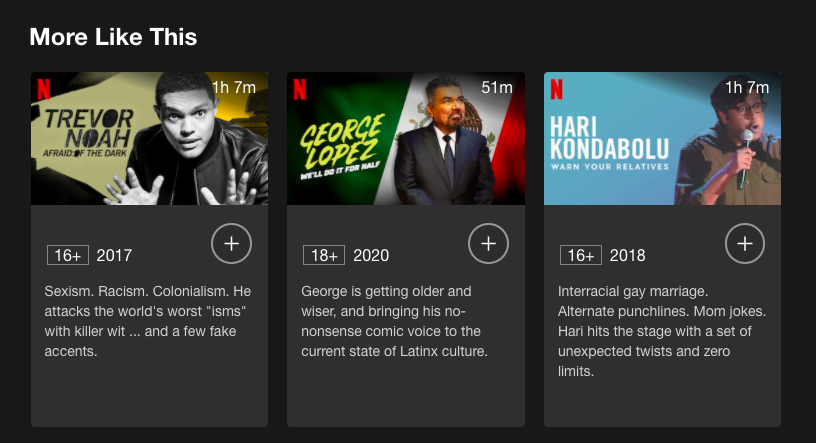

## Dataset

The dataset comes from MovieLens project collected by GroupLens Research at the University of Minnesota. GroupLens have gathered datasets of movie ratings of various sizes ranging from 100,000 to all the way to 20,000,000. Each user has rated at least 20 movies which means we have enough information of all the users in order to analyze their preferences and make recommendations. In order to capture more recent films, I will be using a subset from the largest dataset that has 27,278 movies which were collected between 1995-2015 and published in 2016 (Research paper: http://files.grouplens.org/papers/harper-tiis2015.pdf).

In [158]:
# Importing relevant modules

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from itertools import zip_longest
from tqdm.notebook import tqdm
import math

# scipy
from scipy.sparse.linalg import svds

# Pytorch & Pytorch Lightning
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Random seed
np.random.seed(42)

# configure
%matplotlib inline  
style.use('fivethirtyeight')

## Exploratory Data Analysis

In [30]:
# Loading data

movies_df = pd.read_csv('MovieLens/movie.csv', sep=',')
ratings_df = pd.read_csv('MovieLens/rating.csv', sep=',', parse_dates=['timestamp'])
movies_df.shape, ratings_df.shape

((27278, 3), (20000263, 4))

In [31]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [32]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [33]:
print('There are {} unique users in the database'.format(len(ratings_df['userId'].unique())))

There are 138493 unique users in the database


In [34]:
print('There are {} unique movies in the database'.format(len(ratings_df['movieId'].unique())))

There are 26744 unique movies in the database


In [35]:
ratings_df['rating'].value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

In [36]:
print('From the ratings the average is {} and the median is {}'.format(ratings_df[['userId','rating']].mean()[1], ratings_df[['userId', 'rating']].median()[1]))

From the ratings the average is 3.5255285642993797 and the median is 3.5


There are 138493 people who have given a rating for 26744 movies and most have given a rating of 3 or more out of 5 which indicates most of the movies are either quite good or the people who rate the movies have a bias of giving a good rating rather than a bad one. This should be also accounted when modeling either by normalizing the ratings or by adding a bias term to the users and movies.

In [37]:
def cross_tab(ratings, n=20):
    """Cross-tabular view of users and movie ratings.
    """
    users = ratings_df.groupby('userId')['rating'].count()
    user_group = users.sort_values(ascending=False)[:20]
    
    movies = ratings_df.groupby('movieId')['rating'].count()
    movie_group = movies.sort_values(ascending=False)[:20]
    
    matrix = (
            ratings_df.join(user_group, rsuffix='_r', how='inner', on='userId').
                    join(movie_group, rsuffix='_r', how='inner', on='movieId'))
    
    return pd.crosstab(matrix.userId, matrix.movieId, matrix.rating, aggfunc=np.sum)

cross_tab(ratings_df, movies_df)

movieId,1,32,50,110,150,260,296,318,356,457,480,527,589,592,593,780,1196,1210,2571,2858
userId,,,,,,,,,,,,,,,,,,,,
8405,5.0,4.0,4.5,4.0,4.0,5.0,5.0,4.5,4.5,4.5,4.0,5.0,5.0,4.5,5.0,3.0,5.0,4.0,5.0,4.5
8963,2.5,3.5,3.5,2.0,3.5,5.0,3.0,3.5,3.5,5.0,2.0,4.0,3.0,2.0,5.0,3.0,5.0,3.0,2.5,4.5
15617,NaN,4.5,3.5,4.5,4.0,3.5,4.0,4.0,4.0,4.0,2.5,4.0,4.0,3.5,4.0,3.5,3.5,NaN,5.0,3.5
20132,5.0,4.0,5.0,1.0,4.0,4.0,4.0,5.0,4.0,5.0,NaN,5.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0
34576,4.0,4.0,4.0,4.0,3.5,4.0,4.5,4.0,3.5,3.5,4.0,4.0,4.0,3.5,4.5,3.0,4.0,4.0,4.0,5.0
46470,5.0,4.5,3.0,5.0,4.0,5.0,4.0,5.0,5.0,3.0,2.5,2.5,3.0,5.0,3.5,4.5,4.0,5.0,5.0,3.5
59477,4.5,3.5,4.5,4.5,2.5,4.0,5.0,4.5,4.0,2.5,4.0,4.5,5.0,4.5,3.5,3.5,4.0,3.5,3.5,4.0
63147,4.5,4.0,2.5,3.0,4.0,3.5,4.5,2.5,NaN,3.0,NaN,4.5,2.5,NaN,2.0,2.5,4.5,NaN,3.0,2.5
71975,4.5,4.0,5.0,3.5,4.0,4.5,4.5,4.0,4.5,3.5,4.5,4.0,5.0,4.0,5.0,4.0,5.0,5.0,4.5,5.0


The ratings database doesn't have any missing values, but once we create a user-item matrix of all the users together with all the movie ratings, we see that differences start to arise from those users that have rated many movies to those that haven't rated so many. These missing 'NaN' entries will need to be filled with an algorithm. We will begin to experminent with different models first starting with Neural Networks.

# Collaborative Filtering via Implicit User Preferences

The MovieLens dataset includes 20M recommendations from around 140,000 different users, but we will only need a portion of this to actually test the models so we will pick randomly 30 % of the users and their ratings for the recommendation systems and merge the two datasets into one for easier access.

In [38]:
# Selecting 30 % of users and their ratings from the dataset

rand_userIds = np.random.choice(ratings_df['userId'].unique(), size=int(len(ratings_df['userId'].unique())*0.3), replace=False)
ratings = ratings_df.loc[ratings_df['userId'].isin(rand_userIds)]
print('The dataset has {} ratings from {} users.'.format(len(ratings), len(rand_userIds)))

The dataset has 6048287 ratings from 41547 users.


## Learning from the data

As the data has a timestamp column that shows the date and time the review was submitted, we can use the most recent review from a user as the testing data and the reviews before that as the training data. This leave-one-out methodology is often used when training and evaluating recommender systems as this way we don't introduce possible data leakage with a look-ahead bias due to randomly splitting the data in a way that the most recent reviews could be used as training to evaluate the reviews of the past.

In [40]:
# Leave-one-out train-test-split

ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1] 
test_ratings = ratings[ratings['rank_latest'] == 1]

train_ratings = train_ratings[['userId', 'movieId', 'rating']] 
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

train_ratings.shape, test_ratings.shape

((6006740, 3), (41547, 3))

The first model will use implicit feedback se first we need to reformulate what the rating actually stands for. The rating represents at the moment direct feedback from a movie and this needs to be made implicit by changing the rating from a qualitative description to a quantitative description which can be done by binarizing the rating into whether the user has seen the movie (i.e. rated the movie) or not. Hence, one will indicate the positive class that the user has seen the movie and zero the opposite. By making this change, the prediction also changes from trying to predict a movie rating into predicting whether the user will go see the movie. Whether someone will buy or click something is perhaps more important for businesses than whether they actually liked what they bought or clicked.

In [41]:
# Changing ratings into binary form

train_ratings.loc[:, 'rating'] = 1
test_ratings.loc[:, 'rating'] = 1

train_ratings.head()

,userId,movieId,rating
0,1,2,1
1,1,29,1
2,1,32,1
3,1,47,1
4,1,50,1


The ratings now include only positive classes so next we need to make negative classes to indicate movies which the user would not be interested in seeing. This can be arbitrary, as we don't really know the exact number of movies or even the movies that the user doesn't like, but we could assume that it is more rare to find a very good movie than an average or even a bad one. 

So if we take a random collection of 5 movies for example, there should be a high chance that there is only one or a few that we actually like and the rest we are not that interested of. If you think of going to a movie theater that shows a dozen different movies, we could think that we would be interested of only a few of them, or in the case of a streaming service that offers a wide collection of different movies, once we start scrolling down the catalogue we find ourselves picking only a few of them, as both options often try to capture a variety of different types of movies for a variety of different types of people.

Taking these considerations into account, we will create a ratio of 4:1, as in one movie seen means that there will be 4 other movies that we are not interested of seeing.

In [175]:
class MovieLensImplicitTrainDataset(Dataset):
    """Creates MovieLens PyTorch Dataset for Training.
    
    Args:
        'ratings' : Dataframe containing the movie ratings.
        'all_movieIds' : List containing all unique movieIds.
    
    Returns:
        torch tensors of users, items and labels
    """
    
    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_train_dataset(ratings, all_movieIds)
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        
        return self.users[idx], self.items[idx], self.labels[idx]
    
    def get_train_dataset(self, ratings, all_movieIds):
        # placeholders for the training set
        users, items, labels = [], [], [] 
        # set of items the user has interacted with
        user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId'])) # user interactions
        
        num_negatives = 4 # 4:1 ratio
        
        for (u, i) in tqdm(user_item_set):
            users.append(u)
            items.append(i)
            labels.append(1) # interacted items for the user are positive
            
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds) # random selection
                # check that user has not interacted with the item
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0) # not iteracted items for the user are negative
                
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [176]:
class MovieLensImplicitTestDataset(Dataset):
    """Creates MovieLens PyTorch Dataset for Testing.
    
    Args:
        'ratings' : Dataframe containing the movie ratings
        'all_movieIds' : List containing all unique movieIds
    
    Returns:
        torch tensors of users, items and labels
    """
    
    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_test_dataset(ratings, all_movieIds)
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        
        return self.users[idx], self.items[idx], self.labels[idx]
    
    def get_test_dataset(self, ratings, all_movieIds):
        # placeholders for the training set
        users, items, labels = [], [], [] 
        # set of items the user has interacted with
        user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId'])) # user interactions
        
        num_negatives = 4 # 4:1 ratio
        
        for (u, i) in tqdm(user_item_set):
            users.append(u)
            items.append(i)
            labels.append(1) # interacted items for the user are positive
            
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds) # random selection
                # check that user has not interacted with the item
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0) # not iteracted items for the user are negative
                
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

## Neural Collaborative Filtering

In order to capture the user preferences through Collaborative Filtering, we will use user and item embeddings which capture the user preferences from a high-dimensional vector space into a low-dimensional vector space. 

This way, the users with similar taste in movies should also have similar embeddings. The user embeddings show how the user has interacted with the movies and the item embeddings show how the other users have interacted with the movies, creating eventually collectively the user preferences. The more dimensions you use in the embeddings, the more complex the model becomes so the key will be to learn these embeddings in a straightforward and simple way that enables generalization without the risk of overfitting the data.

As this is now a binary classification problem, the loss function will be the Binary Cross Entropy (BCE) that measures the cross entropy loss between the binary valued target and the input probabilities, and the calculations of the loss will be performed with the Adam optimizer which is a stochastic gradient descent method to calculate the gradients of the loss function.

The inputs to the model are one-hot encoded user and item vectors which are then forwarded to the user and item embedding layers before concatenating together through two fully connected layers. The output layer has a Sigmoid function inorder to determine the most probable class.

In [177]:
# Creating a PyTorch class for the model

class NCF(pl.LightningModule):
    """Neural Collaborative Filtering (NCF) model with 8-dimensional embeddings.
    
    research paper: Xiangnan He, Lizi Liao, Hanwang Zhang,
    Liqiang Nie, Xia Hu, Tat-Seng Chua, (2017),
    "Neural Collaborative Filtering", arXiv:1708.05031. 
    
    Two embedding layers of dimension 8 lead to two fully connected layers of
    16 and 64 parameters. Prediction with the Sigmoid function that forces
    values to be between 0 and 1.
    
    Args:
        'num_users' : Number of unique users (int)
        'num_items' : Number of unique movies (int)
        'ratings'   : Dataframe containing the movie ratings for training
        'all_movieIds' : List containing all unique movieIds (train+test)
    
    Returns:
        predicted labels (0 or 1)
    """
    
    def __init__(self, num_users, num_items, train_ratings, test_ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.loss = nn.BCELoss()
        self.train_ratings = train_ratings
        self.test_ratings = test_ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        
        x = torch.cat([user_embedded, item_embedded], dim=-1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        
        prediction = nn.Sigmoid()(self.output(x))
        
        return prediction
        
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = self.loss(predicted_labels, labels.view(-1,1).float())
        self.log('train_loss', loss, on_epoch=True)
        
        return {'loss': loss}
    
    def test_step(self, test_batch, batch_idx):
        test_users, test_items, test_ratings = test_batch
        test_pred = self(test_users, test_items)
        loss = self.loss(test_pred, test_ratings.view(-1, 1).float())
        self.log('test_loss', loss, prog_bar=True, logger=True)
        
        return {'test_loss':loss, 'test_users': test_users.detach(), 'test_items': test_items.detach(), 'test_pred': test_pred.detach(), 'test_ratings': test_ratings.detach()}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
    def train_dataloader(self):
        return DataLoader(MovieLensImplicitTrainDataset(self.train_ratings, self.all_movieIds), batch_size=512)
    
    def test_dataloader(self):
        return DataLoader(MovieLensImplicitTestDataset(self.test_ratings, self.all_movieIds), batch_size=512)

In [45]:
# Initializing the model

tb_logger = TensorBoardLogger('tb_logger', name='NeuralCollaborativeFiltering')

num_users = ratings['userId'].max()+1 # Number of unique users
num_items = ratings['movieId'].max()+1 # Number of unique ratings

all_movieIds = ratings['movieId'].unique() # Array of movie indices

model = NCF(num_users, num_items, train_ratings, test_ratings, all_movieIds)
model

NCF(
  (user_embedding): Embedding(138491, 8)
  (item_embedding): Embedding(131171, 8)
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (loss): BCELoss()
)

In [152]:
# Training the model by reloading a new random set of negative samples at each epoch

trainer = pl.Trainer(max_epochs=6, reload_dataloaders_every_epoch=True, progress_bar_refresh_rate=50, logger=True, checkpoint_callback=False)
trainer.fit(model)

In [153]:
#  Test error 8 dim, 5 batches, 512 batch size
trainer.test(model)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.26267385482788086}
--------------------------------------------------------------------------------



[{'test_loss': 0.26267385482788086}]

In [154]:
# Saving model
torch.save(model.state_dict(), 'best_weights_model1.pt')

## Evaluating the Recommender System

The model produced a low test error which indicates that the learning process went quite well. To be more specific in how the model works, we can create a list of movies that a specific user would like to see and check whether this list includes the most recent movie that the user has actually seen. Thus, we generate a bundle of movies where the majority of the films consist of randomly picked ones that the user hasn't seen together with the most recent film that the user has seen. Then we run the model to see whether the model manages to pick the most recent film to the top 10 of the movies it has selected. 

This is what we presumed in the beginning that we are more likely to find only one or a few good movies which we would like to see if we would randomly go to a movie theater to see what movies are being projected. We don't need to see all the movies there, just one which we like is enough. 

We then repeat this process for all users and count the average of successess to see how the model performs.

In [155]:
def evaluate_model(model, ratings, test_ratings, all_movieIds):
    """Evaluates the model from a bundle of 100 movies which includes
    one movie that the user has seen most recently and the others which
    the user hasn't seen.
    
    The prediction comes from the forward method of the model and for the output
    we use np.squeeze() to remove unnecessary dimensions from predicted labels
    and detach().numpy() to get a NumPy array from a torch tensor.
    """
    # Placeholder for correct hits
    hits = []
    # user-item pairs for testing
    user_item_test_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
    # Dictionary of interacted items by each user
    user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()
    
    for (u, i) in tqdm(user_item_test_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_movieIds) - set(interacted_items)
        group_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        bundle_items = group_not_interacted + [i]
        
        predicted_labels = np.squeeze(model(torch.tensor([u]*100), torch.tensor(bundle_items)).detach().numpy())
        
        top10 = [bundle_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
        
        if i in top10:
            hits.append(1)
        else:
            hits.append(0)
    
    return np.average(hits)   

In [156]:
evaluate_model(model, ratings, test_ratings, all_movieIds)

0.8138012371531037

The results confirm the previous test result. When evaluating the model with our custom metric, the model produced a very good accuracy of over 81 % which means the model managed to find, by learning with 8 dimensional user and movie embeddings for 33650 users out of 41547 the specific movie the user rated most recently.

It is thus reasonable to assume this model could find a list of movies where at least one or a few of the movies this particular user would enjoy and like to see. Furthermore, this same model could be easily transformed into recommendation of other items such as music, books, or any kind of other products or services that you can find online.

Next we will be exploring two neural network models that give a list of recommended movies based on particular explicit user preferences.

# Collaborative Filtering via Explicit User Preferences

For the remainder of the models, the learning will happen through explicit interactions from the user ratings and all the ratings will be treated equally, no mather how recently or far back in time a movie has been rated. This will make the learning process more difficult, as there will be less of training data and more of testing data, but also because now we need to predict the actual rating instead of a boolean yes or no.

The splitting of the dataset more randomly can be argumented if we assume for example that taste and preferences of people take a long time to develop so that a sudden change is not very common or we should at least except the change to happen gradually through time. Moreover, some movies that are part of a series, for example the Marvel movies, might have a sequel or they continue from the first part, like in the Guardians of the Galaxy, but it dosn't really matter in which order you see these movies as they don't really reveal so much of the "main" plot so that the viewing experience would be ruined if you hadn't see the first one before the last one. This is actually true to many of the recently made movies, at least after the Millenium, which has been perhaps a decision taken by the production companies in order to accumulate as many people as possible to the cinemas; as even those people that haven't seen the previous movies of a particular series (e.g. James Bond, Jason Bourne, Mission Impossible, etc.) might be tempted to see the latest movie of the series.

## Learning from the data

The learning will happen again through the embeddings, where the users and movies will first be encoded as integer indices and made into sets by first splitting with 80:20 ratio into training and testing sets, and then continued on with a 90:10 split into training and validation sets respectively.

The predictions will be more difficult than before, as the test dataset is now larger and we are going to make predictions no matter when a rating was made which makes the calculations more difficult. For the model the dimensions of the vector embeddings will thus be increased and for the first model we will use the product to calculate the similarities between the users and the movies. The filling of the missing entries of the ratings will happen gradually again with the gradient descent algorithm. We will also normalize the ratings and include a bias term for the users and for the movies to incorporate for the bias that might arise when people give a rating that is too extreme (i.e. too generous or too negative), and to incorporate so that the movies would represent better themselves rather than the average of all the movies. So to start everything off, first we create a function that handles all the data the models.

In [178]:
# Function to prepare data

class MovieLensDataset(Dataset):
    """Prepares MovieLens PyTorch Dataset.
    
    The dataset is split into training, validating and testing sets. Separate functions
    prepare each set after the split.
    
    Args:
        'ratings' : Dataframe containing the movie ratings
    
    Returns:
        Tensors of users, items, and labels for training, validating and testing
    """
    def __init__(self, ratings):
        super().__init__()
        
        self.ratings = ratings
        self.train_data, self.val_data, self.test_data = self._setup(ratings)
        self.train_users, self.train_items, self.train_labels = self.get_training_data(self.train_data)
        self.val_users, self.val_items, self.val_labels = self.get_val_data(self.val_data)
        self.test_users, self.test_items, self.test_labels = self.get_test_data(self.test_data)
        self.n_users = len(ratings['userId'].unique())
    
    def __len__(self):
        return self.n_users
    
    def __getitem__(self, idx):
        return self.train_users[idx], self.train_items[idx], self.train_labels[idx]
    
    def _setup(self, ratings):
        
        # Mapping user indices
        users_unique = ratings.userId.unique()
        userid2idx = {x:u for u,x in enumerate(users_unique)}
        ratings['user_id'] = ratings['userId'].map(userid2idx)
    
        # Mapping movie indices
        movies_unique = ratings.movieId.unique()
        movieid2idx = {x:i for i,x in enumerate(movies_unique)}
        ratings['movie_id'] = ratings['movieId'].map(movieid2idx)
        
        X = ratings[['user_id', 'movie_id']].values
        y = ratings['rating'].astype(np.float32)
    
        # Normalizing data
        min_rating = min(ratings['rating'])
        max_rating = max(ratings['rating'])
        
        y = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    
        # Splitting data into training and testing sets
        train_indices = int(0.8 * ratings.shape[0])
        X_train = X[:train_indices]
        y_train = y[:train_indices]
        X_test = X[train_indices:]
        y_test = y[train_indices:]
        
        test_users = X_test[:,0]
        test_items = X_test[:,1]
        test_labels = y_test
        
        # Splitting training data into training and validating sets
        val_indices = int(0.9 * len(X_train))
        X_val = X_train[val_indices:]
        y_val = y_train[val_indices:]
        X_train = X_train[:val_indices]
        y_train = y_train[:val_indices]
        
        val_users = X_val[:,0]
        val_items = X_val[:,1]
        val_labels = y_val
        
        train_users = X_train[:,0]
        train_items = X_train[:,1]
        train_labels = y_train
        
        train_data = [train_users, train_items, train_labels]
        val_data = [val_users, val_items, val_labels]
        test_data = [test_users, test_items, test_labels]
        
        return train_data, val_data, test_data
               
    def get_training_data(self, train_data):
        users, items, labels = train_data
        
        return torch.LongTensor(users), torch.LongTensor(items), torch.FloatTensor(labels)
     
    def get_val_data(self, val_data):
        users, items, labels = val_data
        
        return torch.LongTensor(users), torch.LongTensor(items), torch.FloatTensor(labels)
    
    def get_test_data(self, test_data):
        users, items, labels = test_data
        
        return torch.LongTensor(users), torch.LongTensor(items), torch.FloatTensor(labels)

## The Model 

When training deep neural networks, the learning rate is one of the most important hyper-parameters you can tune. It is often made to decay slowly as time goes by inorder to find the sweet spot and achieve best results through the learning process. However, the right rate can be difficult to find and takes a long time to fine-tune. One approach to find the right rate quicker is to use a Cyclical Learning Rate (CLR) that eliminates the need to experiment with different learning rates as the method lets the rate to cyclically vary between a boundary of values. 

We will create a CLR that follows a cosine annealing scheduler where we can choose from two options: either the rate acts like a wave in the ocean (i.e. the rate has a form of a rising and descending wave following the cosine function) or the learning rate is slowly decaying. The idea is that we start our search for the optimum parameters with a high learning rate and gradually decrease the rate with more iterations in order to stay at the local minimum and not accidentaly take a too large step and loose the sight of progress. In the first option, we repeatedly restart this process, as in the form of a warm restart, to bring the learning rate up again before gradually decreasing the rate till the end. This decaying learning rate, and also dropping the batch size to 32 will help our model to find more stable solution with each iteration. 

We are now trying to predict the actual explicit ratings that have a range from 0 to 5, so to control for the accuracy in the training process we will use the Mean Squared Error (MSE), that is the average of the squared differences between a set of values and predictions. This will measure the quality of the recommender as it incorporates both the variance - the spread of the estimates - and the bias - how far off the average estimated value is from the true value. Other accuracy methods include the Root Mean Squared Error (RMSE) which is the square root of the MSE and the Mean Absolute Error (MAE) which measures the average of the absolute differences between a set of values and predictions. All these metrics would work in a similar way, the differense being that the first two penalize large errors more heavily.

Finally, to see how the model actually performs, we will make movie recommendations for some user and see what kind of movies the model recommends.

In [47]:
# CLR based on cosine annealing

class CyclicLR(_LRScheduler):
    """A Cyclical Learning Rate based on cosine annealing that inherits
    get_lr() from the PyTorch scheduler class.
    
    Research paper: Leslie N. Smith, (2017), "Cyclical Learning Rates for
    Training Neural Networks", arXiv:1506.01186 
    """
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)
        
    def get_lr(self):
        """Returns a list of learning rates depending on the current training epoch.
        """
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
def cosine_annealing(t_max, eta_min=0):
        
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi * t / t_max)) /2
        
    return scheduler

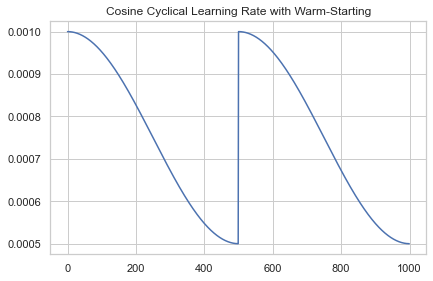

In [48]:
# Plotting Cosine annealing CLR with warm start

ts = list(range(1000))
y = [cosine_annealing(t_max=500, eta_min=0.0005)(t, 0.001) for t in ts]
plt.title('Cosine Cyclical Learning Rate with Warm-Starting')
plt.plot(ts, y)
plt.show()

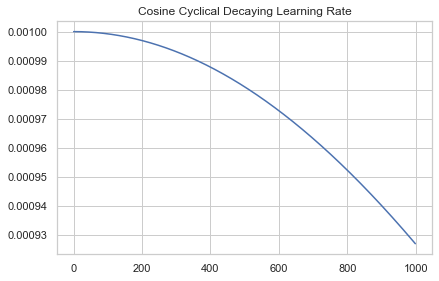

In [49]:
# Plotting Cosine annealing CLR with decaying learning rate

ts = list(range(1000))
y = [cosine_annealing(t_max=4000, eta_min=0.0005)(t, 0.001) for t in ts]
plt.title('Cosine Cyclical Decaying Learning Rate')
plt.plot(ts, y)
plt.show()

In [179]:
# Neural Matrix Factorization Model

class NeuralMatrixFactorization(pl.LightningModule):
    """Neural Network that works like matrix factorization through the product
       added with user and movie bias terms in order to calculate similarities between
       users and movies.
    
    Args:
        'num_users' : Number of unique users (int)
        'num_items' : Number of unique movies (int)
        'ratings'   : Dataframe containing the movie ratings
    
    Returns:
        predicted ratings
    """
    def __init__(self, num_users, num_items, ratings):
        super().__init__()

        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=25)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=25)
        self.user_bias = nn.Embedding(num_embeddings=num_users, embedding_dim=1)
        self.item_bias = nn.Embedding(num_embeddings=num_items, embedding_dim=1)
        self.loss = nn.MSELoss(reduction='sum')
        self.ratings = ratings
    
    def forward(self, users, items):
        
        dot = self.user_embedding(users) * self.item_embedding(items)
        predictions = dot.sum(1) + self.user_bias(users).squeeze() + self.item_bias(items).squeeze()
        predictions = nn.Sigmoid()(predictions)
          
        return predictions
      
    def training_step(self, train_batch, batch_idx):
        users, items, ratings = train_batch
        predicted_labels = self(users, items)
        loss = self.loss(predicted_labels.view(-1), ratings)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        
        return {'loss': loss}
        
    def validation_step(self, valid_batch, batch_idx):
        val_users, val_items, val_ratings = valid_batch
        val_pred = self(val_users, val_items)
        loss = self.loss(val_pred.view(-1), val_ratings)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        return {'val_loss': loss, 'val_users': val_users.detach(), 'val_items': val_items.detach(), 'val_pred': val_pred.detach(), 'val_ratings': val_ratings.detach()}
    
    def test_step(self, test_batch, batch_idx):
        test_users, test_items, test_ratings = test_batch
        test_pred = self(test_users, test_items)
        loss = self.loss(test_pred.view(-1), test_ratings)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        
        return {'test_loss':loss, 'test_users': test_users.detach(), 'test_items': test_items.detach(), 'test_pred': test_pred.detach(), 'test_ratings': test_ratings.detach()}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = CyclicLR(optimizer, cosine_annealing(t_max=4000, eta_min=0.0005))
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def train_dataloader(self):
        return DataLoader(MovieLensDataset(self.ratings), batch_size=32)
    
    def val_dataloader(self):
        return DataLoader(MovieLensDataset(self.ratings), batch_size=32)
    
    def test_dataloader(self):
        return DataLoader(MovieLensDataset(self.ratings), batch_size=32)

In [53]:
# Initializing the model

tb_logger = TensorBoardLogger('tb_logger', name='NeuralMatrixFactorization')

num_users = ratings['userId'].max()+1 # Number of unique users in the whole dataset
num_items = ratings['movieId'].max()+1 # Number of unique ratings in the whole dataset

model_2 = NeuralMatrixFactorization(num_users, num_items, ratings)
model_2

NeuralMatrixFactorization(
  (user_embedding): Embedding(138491, 25)
  (item_embedding): Embedding(131171, 25)
  (user_bias): Embedding(138491, 1)
  (item_bias): Embedding(131171, 1)
  (loss): MSELoss()
)

In [88]:
# Training the model

trainer = pl.Trainer(max_epochs=31, reload_dataloaders_every_epoch=False, progress_bar_refresh_rate=50, logger=tb_logger, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)], checkpoint_callback=False)
trainer.fit(model_2)

In [89]:
# trainer with dim 25, 30 epochs, 32 batch size

trainer.test(model_2)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.18592053651809692}
--------------------------------------------------------------------------------



[{'test_loss': 0.18592053651809692}]

In [90]:
# Saving model
torch.save(model_2.state_dict(), 'best_weights_model2.pt')

## Evaluating the Recommender System

We trained the model for 30 epochs, and the learning process went well as the model produced a very low test error of 0.186 from the ratings it hadn't seen before. So now we are ready to evaluate how the model actually performs. For this, we will create a list of recommended movies that a user hasn't seen before based on a few highly rated movies the user has seen before. 

In [91]:
def make_recommendation(model, ratings, movies):
    """Creates a list of recommended movies that the user hasn't seen before based
    on the learned embeddings.
    """
    
    user_id = ratings.userId.sample(1).iloc[0]
    movies_watched_by_user = ratings[ratings.userId == user_id]
    movies_not_watched = ratings[~ratings["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    movie_ids = ratings["movieId"].unique().tolist()
    movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    
    user_ids = ratings["userId"].unique().tolist()
    user2user_encoded = {x: i for i, x in enumerate(user_ids)}
    user_encoder = user2user_encoded.get(user_id)
    
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    predicted_ratings = model(torch.LongTensor(user_movie_array[:,0]), torch.LongTensor(user_movie_array[:,1]))
    predictions =  np.squeeze(predicted_ratings.detach().numpy())
    top_ratings_indices = predictions.argsort()[-10:][::-1]
    movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    
    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 10)
    print("Movies with high ratings from user")
    print("----" * 9)
    
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
    movie_df_rows = movies[movies["movieId"].isin(top_movies_user)]
    
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 7)
    print("Top 10 movie recommendations")
    print("----" * 7)
    
    recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)

In [92]:
make_recommendation(model_2, ratings, movies_df)

Showing recommendations for user: 12767
Movies with high ratings from user
------------------------------------
Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983) : Documentary
Hud (1963) : Drama|Western
Hustler, The (1961) : Drama
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
----------------------------
Top 10 movie recommendations
----------------------------
Roman Holiday (1953) : Comedy|Drama|Romance
Purple Rose of Cairo, The (1985) : Comedy|Drama|Fantasy|Romance
Little Big Man (1970) : Western
Far and Away (1992) : Adventure|Drama|Romance
Inherit the Wind (1960) : Drama
Joe Dirt (2001) : Adventure|Comedy|Mystery|Romance
Bourne Identity, The (2002) : Action|Mystery|Thriller
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
How to Train Your Dragon (2010) : Adventure|Animation|Children|Fantasy|IMAX
Frozen (2013) : Adventure|Animation|Comedy|F

We picked a random user who to give recommendations, and we can see from the previous high ratings of this particular pick that the task will be quite challenging, as the movies have a timspan of 40 years, from the 1960s to 2000s, and all five movies come from a complitely different genre; a documentary, a western, a drama, a romantic comedy, and as a last pick an adventure fantasy.

The model recommendations seemed to be up to the task however and produced very good results. They also have a wide timespan, ranging from all the way from the 1950s to more recent 2010s. A quick search shows that most of the movies have gotten quite good reviews from the critics and from people in general. The only movie that has gotten really mixed positive and negative reviews is Joe Dirt. The genres seem to be also matching pretty well, only a documentary is missing, but we still have a large and wide selection of movies that could attrack younger or older crowds, and if we think similarly than before, that a person will probably be interested of just one or a few movies offered, the recommendations seem to be doing just that.  

## Neural Network Movie Recommender

The model performed quite well, but we also gave the direction where to go, so this time, we will only provide the model architecture and the embeddings, and let the algorithm decide on itself how to learn and optimize the right parameters.

The model uses the same cyclical learning rate and embeddings as before, but we will increase the dimensions of the embeddings a bit and include a number of fully connected layers and dropout layers. The model archutecture is built in a flexible way that lets you to adjust how many connected or dropout layers you want to have, and also what kind of dropout rate the dropout layers should have. Here, the dropout layers stand for layers that randomly drop some of the parameters going through the network, making the model less certain of taking a particular direction and also helping the model to not overfit so easily.

Next, we create the model class, initiate the training routine, and evaluate the results with the test error and with the predicted movies the model comes up with.

In [180]:
# Creating a PyTorch class for the model

class NeuralNetworkMovieRecommender(pl.LightningModule):
    """The idea for the model comes from Ilia Zaitsev
    https://github.com/devforfu/pytorch_playground/blob/master/movielens.ipynb
    
    The generator enables to create an architecture where the number of 
    fully connected hidden layers and dropout layers as well as the
    rate of the dropout layers are all adjustable. The weights
    of the hidden layers as well as the emebedding layers are initialized
    from a uniform distribution.
    
    Args:
        'num_users' : Number of unique users (int)
        'num_items' : Number of unique movies (int)
        'hidden'    : Numer of units in hidden layers added as a list
        'dropouts'  : Dropout layer rate added as a list
        'ratings'   : Dataframe containing the movie ratings for training
        
    """
    
    def __init__(self, num_users, num_items, ratings, hidden=10, dropouts=0.2):
        super().__init__()
        
        def get_list(n):
            if isinstance(n, (int, float)):
                return [n]
            elif hasattr(n, '__iter__'):
                return list(n)
        
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def generate_layers(num_in):
            """Generator that creates hidden and dropout layers.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for num_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(num_in, num_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                num_in = num_out
        
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=50)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=50)
        self.drop = nn.Dropout(0.02)
        self.hidden = nn.Sequential(*list(generate_layers(50 * 2)))
        self.output = nn.Linear(n_last, 1)
        self._init()
        self.loss = nn.MSELoss(reduction='sum')
        self.ratings = ratings
        
        
    def forward(self, user_input, item_input):
        
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        
        x = torch.cat([user_embedded, item_embedded], dim=1)
        x = self.drop(x)
        x = self.hidden(x)
        
        prediction = nn.Sigmoid()(self.output(x))
        
        return prediction
    
    def _init(self):
        """Setup for initial values for embeddings and hidden layers.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        
        self.user_embedding.weight.data.uniform_(-0.05, 0.05)
        self.item_embedding.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.output)
    
    def training_step(self, train_batch, batch_idx):
        users, items, ratings = train_batch
        predicted_labels = self(users, items)
        loss = self.loss(predicted_labels.view(-1), ratings)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        
        return {'loss': loss}
        
    def validation_step(self, valid_batch, batch_idx):
        val_users, val_items, val_ratings = valid_batch
        val_pred = self(val_users, val_items)
        loss = self.loss(val_pred.view(-1), val_ratings)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        return {'val_loss': loss, 'val_users': val_users.detach(), 'val_items': val_items.detach(), 'val_pred': val_pred.detach(), 'val_ratings': val_ratings.detach()}
    
    def test_step(self, test_batch, batch_idx):
        test_users, test_items, test_ratings = test_batch
        test_pred = self(test_users, test_items)
        loss = self.loss(test_pred.view(-1), test_ratings)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        
        return {'test_loss':loss, 'test_users': test_users.detach(), 'test_items': test_items.detach(), 'test_pred': test_pred.detach(), 'test_ratings': test_ratings.detach()}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = CyclicLR(optimizer, cosine_annealing(t_max=4000, eta_min=0.0005))
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def train_dataloader(self):
        return DataLoader(MovieLensDataset(self.ratings), batch_size=32)
    
    def val_dataloader(self):
        return DataLoader(MovieLensDataset(self.ratings), batch_size=32)
    
    def test_dataloader(self):
        return DataLoader(MovieLensDataset(self.ratings), batch_size=32)
    

In [151]:
# Initializing the model

num_users = ratings['userId'].max()+1 # Number of unique users in the whole dataset
num_items = ratings['movieId'].max()+1 # Number of unique ratings in the whole dataset

tb_logger = TensorBoardLogger('tb_logger', name='NeuralNetworkMovieRecommender')

model_3 = NeuralNetworkMovieRecommender(num_users, num_items, ratings)

model_3

NeuralNetworkMovieRecommender(
  (user_embedding): Embedding(138491, 50)
  (item_embedding): Embedding(131171, 50)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (output): Linear(in_features=10, out_features=1, bias=True)
  (loss): MSELoss()
)

In [119]:
# Training the model

trainer = pl.Trainer(max_epochs=31, reload_dataloaders_every_epoch=False, progress_bar_refresh_rate=50, logger=tb_logger, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)], checkpoint_callback=False)
trainer.fit(model_3)

In [120]:
# Trainer with 50 dim, 32 batch size, 30 epochs

trainer.test(model_3)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7785917520523071}
--------------------------------------------------------------------------------



[{'test_loss': 0.7785917520523071}]

In [121]:
# Saving model
torch.save(model_3.state_dict(), 'best_weights_model3.pt')

After training for 30 epochs we get a test error result of around 0.779 which is quite low but not as good as before. We will again make some recommendations to see how the model actually performs.

In [132]:
make_recommendation(model_3, ratings, movies_df)

Showing recommendations for user: 761
Movies with high ratings from user
------------------------------------
Braveheart (1995) : Action|Drama|War
Shawshank Redemption, The (1994) : Crime|Drama
Apocalypse Now (1979) : Action|Drama|War
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Pleasantville (1998) : Comedy|Drama|Fantasy
----------------------------
Top 10 movie recommendations
----------------------------
Man Who Would Be King, The (1975) : Adventure|Drama
You Can't Take It with You (1938) : Comedy|Romance
Days of Heaven (1978) : Drama
Inherit the Wind (1960) : Drama
Auntie Mame (1958) : Comedy|Drama
The Big Sleep (1978) : Thriller
2 Days in Paris (2007) : Comedy|Drama|Romance
RocknRolla (2008) : Action|Crime
Last Circus, The (Balada triste de trompeta) (Sad Trumpet Ballad, A) (2010) : Comedy|Drama|War
Louis C.K.: Hilarious (2010) : Comedy


We pick again a random user and see a list of five movies the user has enjoyed in the past. This time we have a selection of movies from the end of the 1970s until the end of 1990s, where we have two action style drama-war movies, one Film-Noir type mystery-crime-thriller, one crime-drama and one comedy that has some drama and fantasy blended together. I have personally seen the four first ones on the list which I enjoyed a lot and which I think stands as classic movies in their respective genres so I am really looking forward what the recommendations this time will show.

A quick glance at the recommendations show the timespan going from the end of the 1930s all the way to 2010s, making again a surprisingly wide selection through the years. Why did the model choose a wide timespan like this; makes me think this could be either quite an amazing selection or just a random collection of movies. I do not know most the recommended movies, but a more careful search shows that most of the recommended movies have actually gotten quite good reviews from the critics and people in general. However, I can't help myself thinking that it is quite a gamble to propose movies from the 1930s and 1950s for someone who indicates liking a list of movies from the 70s till the 90s. A black and white old movie is not quite the same as the movies we have now, so this time I am not so convinced these recommendations could actually work for the selected user, although I have to say there are two movies which I have seen before from the recommendations (RocknRolla and Louis C.K.: Hilarious) which I also liked, perhaps not as much the four movies before, but if I wouldn't hadn't seen them, I would have put them on my watch list as I enjoy Guy Ritchie's movies and I think Louis C.K. is actually quite funny. So overall, if we again presume a person should enjoy at least one or a few movies from the list, then this model passed the test.

## Matrix Factorization with Singular Value Decomposition

For the final model, we will use matrix factorization with Singular Value Decomposition (SVD) to compare with the predictions we got from the previous models. Compared to the other previous models, we don't need to wait for the model to train and learn anything as we only need to perform some linear algebra. Moreover, matrix factorization is the breaking down of one matrix into a product of multiple matrices which can be done SVD which is an algorithm that decomposes a matrix $R$ into the best lower rank approximation of the original matrix $R$. Mathematically, it decomposes $R$ into two unitary matrices and a diagonal matrix:

$$\begin{equation} R = U\Sigma V^{T} \end{equation}$$

where $R$ is user ratings matrix, $U$ is the user features matrix that describes user preferences on the movies, $\Sigma$ is the diagonal matrix of singular values (i.e. weights), and $V^{T}$ is the movie features matrix that indicates how relevant each feature is to each movie. 

To get the lower rank approximation we take the top $k$ features which are the most important to underly taste and preference vectors.

First we will create a user-item matrix and fill the missing values with zeros, and then normalize the ratings according to each user by substracting the mean of each user from the rating. After creating predicted ratings with the SVD, we recreate the two predictions we created before and analyze the results.

In [99]:
# Creating user-item matrix

ratings_svd = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

ratings_svd.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,131017,131019,131027,131080,131110,131158,131164,131166,131168,131170
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,4.0,0.0,0.0,0.0,2.0,4.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Normalizing the ratings with the mean

R = ratings_svd.to_numpy()
user_ratings_mean = np.mean(R, axis=1)
R_scaled = R - user_ratings_mean.reshape(-1,1)
R_scaled.shape

(41547, 22836)

In [101]:
# Singular Value Decomposition with 50 features

U, sigma, Vt = svds(R_scaled, k = 50)

In [102]:
# Making predictions with dot-product and adding the mean back for each user

sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
all_user_predicted_ratings.shape

(41547, 22836)

In [103]:
# Creating a dataframe from the predictions

preds_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_svd.columns)

In [181]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations):
    """Makes a list of recommendated movies that the user hasn't seen before.
    """
    user_row_number = userID-1  
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
      
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 ).head(5)
    
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations+1, :-1]
                      )  

    print("Showing recommendations for user: {}".format(userID))
    print("====" * 10)
    print("Movies with high ratings from user")
    print("----" * 9)
    
    movie_df_rows = movies_df[movies_df["movieId"].isin(user_full.movieId)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 7)
    print("Top 10 movie recommendations")
    print("----" * 7)
    
    recommended_movies = movies_df[movies_df["movieId"].isin(recommendations.movieId)]
    
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)  

In [134]:
recommend_movies(preds_df, 12767, movies_df, ratings, 10)

Showing recommendations for user: 12767
Movies with high ratings from user
------------------------------------
Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983) : Documentary
Hud (1963) : Drama|Western
Hustler, The (1961) : Drama
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
----------------------------
Top 10 movie recommendations
----------------------------
Heat (1995) : Action|Crime|Thriller
Seven (a.k.a. Se7en) (1995) : Mystery|Thriller
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Clerks (1994) : Comedy
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Godfather, The (1972) : Crime|Drama
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
American Pie (1999) : Comedy|Romance
Fight Club (1999) : Action|Crime|Drama|Thriller


In [142]:
recommend_movies(preds_df, 761, movies_df, ratings, 10)

Showing recommendations for user: 761
Movies with high ratings from user
------------------------------------
Braveheart (1995) : Action|Drama|War
Shawshank Redemption, The (1994) : Crime|Drama
Apocalypse Now (1979) : Action|Drama|War
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Pleasantville (1998) : Comedy|Drama|Fantasy
----------------------------
Top 10 movie recommendations
----------------------------
Apollo 13 (1995) : Adventure|Drama|IMAX
Crimson Tide (1995) : Drama|Thriller|War
Die Hard: With a Vengeance (1995) : Action|Crime|Thriller
Net, The (1995) : Action|Crime|Thriller
Outbreak (1995) : Action|Drama|Sci-Fi|Thriller
While You Were Sleeping (1995) : Comedy|Romance
Clear and Present Danger (1994) : Action|Crime|Drama|Thriller
True Lies (1994) : Action|Adventure|Comedy|Romance|Thriller
Cliffhanger (1993) : Action|Adventure|Thriller
Dances with Wolves (1990) : Adventure|Drama|Western
Batman (1989) : Action|Crime|Thriller


We have the same users as before and the list of 5 movies these users have liked in the past, but this time we can immediately see a big difference in the recommendations compared to what they were previously. Now the timespan of the movies is much tightly packed than previously, ranging from the 1970s till the 1990s for the first user, and from the 1980s till the 1990s for the second user. For the latter user this perhaps would be a more accurate selection of movies, as it more reflects what the user has also liked before, but for the first user, personally I would have liked to see a more wider selection between the years than a concentration like this one, although this time, the recommended movies have Oscar winners and movies that can be said to define their genres and the time these movies came out, like the Godfather, Pulp Fiction or Dances with Wolves. These movies are actually really good and definitely worth seeing if you haven't seen them before so we can say the model produced really good recommendations. However, the recommendations do come with a caveat, and that is the more narrow timespan and one-type genre the algorithm seems to produce, as we can see most of the first list is of crime movies and the second of action movies. Personally, I have seen almost every movie on the first list, except one (Clerks) and also most the movies from the second list, so for me at least, even though these lists perhaps produced a more accurate selection of movies regarding each user, there is some randomness in the form of "surprises" that is missing, which I did enjoy to see on the other previous lists.